In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.metrics import mean_absolute_error
def plcc_metric(y_true, y_pred):  
    mx = K.mean(K.constant(y_true))
    my = K.mean(K.constant(y_pred))
    xm, ym = y_true-mx, y_pred-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den

# 정규화 함수 
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)            # np.min(data,0) 이었는데 - 값이 있어서 0이 더 작은 값으로 되서 0으로 나누는 경우 에러
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 

df = pd.read_csv("/content/gdrive/MyDrive/tr.csv" , encoding='cp949')
Date = df.iloc[:,0]
df = df.iloc[:, 1:]                   # 맨 앞의 Date는 제외

#df = df.transpose()                  # 행이랑 열 바꿔서 피쳐로 해보자 

from sklearn.preprocessing import MinMaxScaler                    # 얘를 하면 들어온 애의 shape 그대로 다시 back 할 수 있구나
sc = MinMaxScaler()

df = df.interpolate()       # 선형 보간

xy = df.values        

window = 5                          # window size
trainSize = 320                       # 80%만 train
def MinMaxScaler(data):
    denom = np.max(data,0)-np.min(data,0)            # np.min(data,0) 이었는데 - 값이 있어서 0이 더 작은 값으로 되서 0으로 나누는 경우 에러
    nume = data-np.min(data,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 
#trainSet = MinMaxScaler(xy[0:trainSize])
#testSet = MinMaxScaler(xy[trainSize-window:])

trainx = sc.fit_transform((xy[0:trainSize,1:]))
trainy = sc.fit_transform((xy[0:trainSize,[0]]))
testx = sc.fit_transform(xy[trainSize-window:,1:])
testy = sc.fit_transform((xy[trainSize-window:,[0]]))

trainSet = np.concatenate((trainy, trainx), axis=1)
testSet = np.concatenate((testy, testx), axis=1)

predict_day = 4

def buildDataSet(data, window):
    xdata = []
    ydata = []
    for i in range(0, len(data) - window - predict_day):
        xdata.append(data[i:i + window])                         
        ydata.append(data[i + window + predict_day - 1,[0]])                   # 행은 그 다음 행 하나랑, 열은 Number만
    return np.array(xdata), np.array(ydata)
    
lstm_trainX, trainY=buildDataSet(trainSet, window)
lstm_testX, testY=buildDataSet(testSet, window)

trainX = np.transpose(lstm_trainX,(0,2,1))              # Attention에 넣어줄 애만 전치
testX = np.transpose(lstm_testX,(0,2,1))                # 5,31 ---> 31,5 로 전치


trainX.shape,trainY.shape,testX.shape,testY.shape

((311, 31, 5), (311, 1), (199, 31, 5), (199, 1))

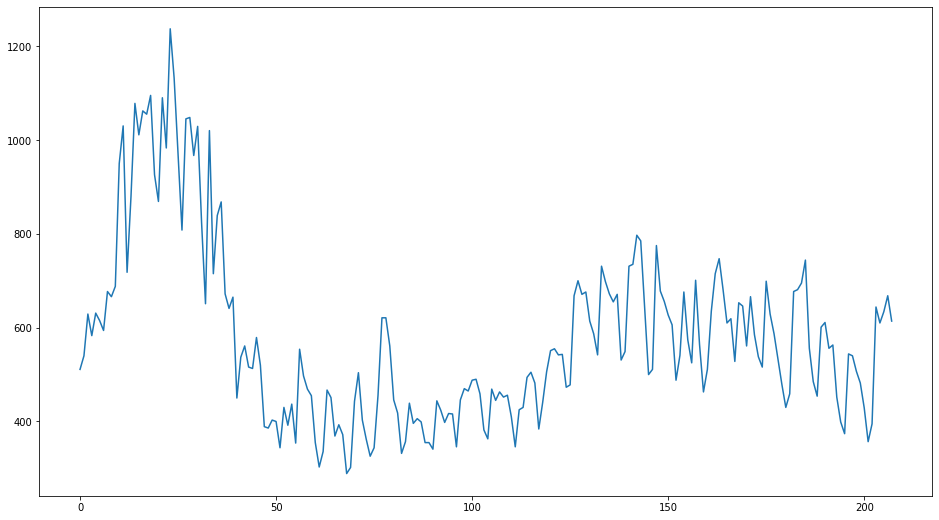

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(xy[trainSize-window:,[0]], label = "정규화 전 Actual Test Y")

In [ ]:
sum_predict = 0
for i in range(5):
  model = keras.Sequential()

  model.add(layers.LSTM(units=32, input_shape=[5,31]))     # LSTM에서는 5,31로 lstm_trainX로 넣어준다
  model.add(layers.Dense(1))    # 하나 나온 값이 예측한 주가
  model.compile(loss='mse', optimizer='adam', metrics=['mae'])

  model.fit(lstm_trainX, trainY, epochs=30, batch_size=16)
  prediction = model.predict(lstm_testX)
  sum_predict += prediction

Epoch 1/30
20/20 [==============================] - 2s 4ms/step - loss: 0.0223 - mae: 0.0976
Epoch 2/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0125 - mae: 0.0660
Epoch 3/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0098 - mae: 0.0612
Epoch 4/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0094 - mae: 0.0661
Epoch 5/30
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - mae: 0.0580
Epoch 6/30
20/20 [==============================] - 0s 5ms/step - loss: 0.0064 - mae: 0.0525
Epoch 7/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0060 - mae: 0.0507
Epoch 8/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0057 - mae: 0.0522
Epoch 9/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0053 - mae: 0.0519
Epoch 10/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - mae: 0.0455
Epoch 11/30
20/20 [==============================] - 0s 4ms/step - lo

In [ ]:
sum_predict = sum_predict/5
actual = sc.inverse_transform(testY.reshape(-1,1))
predict = sc.inverse_transform(sum_predict.reshape(-1,1))

RMSE Evaluate : 222.15796909369757
PCC : 0.6370552778244019


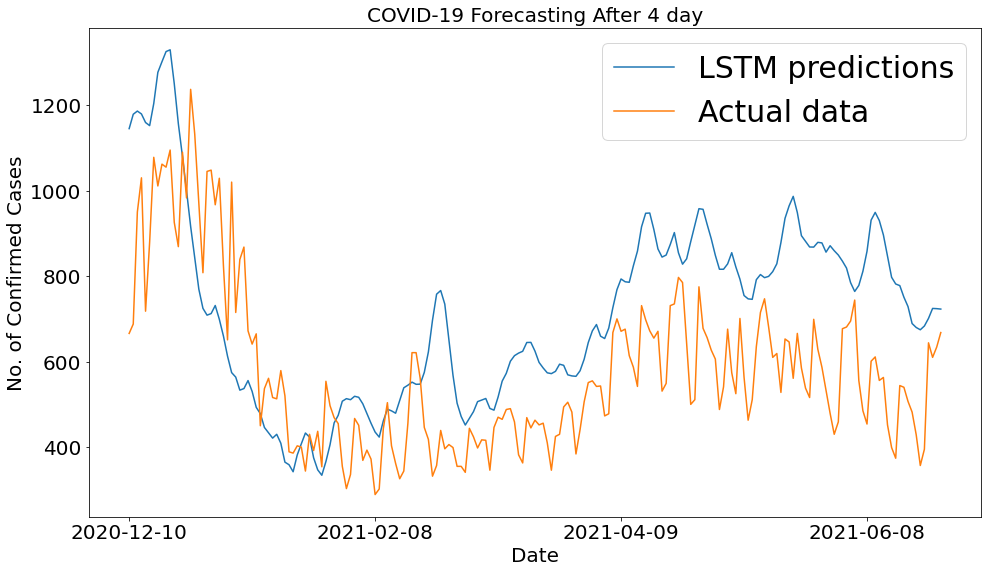

In [ ]:
print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict)**0.5)) 
print("PCC : {}".format(plcc_metric(actual,predict)))
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict, label = "LSTM predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 4 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TIME_STEPS = 31
INPUT_DIM  = 5

def attention_3d_block(inputs):
    
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    
    a = tf.keras.layers.Permute((2, 1))(inputs) # same transpose
    #a = tf.keras.layers.Reshape((input_dim, TIME_STEPS))(a) 
    # this line is not useful. It's just to know which dimension is what.
    a = tf.keras.layers.Dense(TIME_STEPS, activation='softmax')(a)
    
    a_probs = tf.keras.layers.Permute((2, 1), name='attention_vec')(a)
    
    output_attention_mul  = tf.keras.layers.multiply([inputs, a_probs])
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

def model_attention_applied_after_lstm():
    
    inputs        = tf.keras.Input(shape=(TIME_STEPS, INPUT_DIM,))

    lstm_out      = tf.keras.layers.LSTM(units = 32, return_sequences=True)(inputs)
    
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = tf.keras.layers.Flatten()(attention_mul)
    
    output        = tf.keras.layers.Dense(1, activation='tanh')(attention_mul)
    
    model         = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

def model_attention_applied_before_lstm():
    
    inputs        = tf.keras.Input(shape=(TIME_STEPS, INPUT_DIM,))
    
    attention_mul = attention_3d_block(inputs)
    attention_mul = tf.keras.layers.LSTM(units = 32, return_sequences=False)(attention_mul)    
    output        = tf.keras.layers.Dense(1, activation='tanh')(attention_mul)
    
    model         = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [ ]:
sum_predict2 = 0
for i in range(5):
  model2 = model_attention_applied_after_lstm()
  model2.compile(loss='mse', optimizer='adam', metrics=['mae'])

  model2.fit(trainX, trainY, epochs=30, batch_size=16)
  prediction2 = model2.predict(testX)
  sum_predict2 += prediction2

Epoch 1/30
20/20 [==============================] - 2s 13ms/step - loss: 0.0367 - mae: 0.1127
Epoch 2/30
20/20 [==============================] - 0s 12ms/step - loss: 0.0256 - mae: 0.1155
Epoch 3/30
20/20 [==============================] - 0s 12ms/step - loss: 0.0246 - mae: 0.1088
Epoch 4/30
20/20 [==============================] - 0s 12ms/step - loss: 0.0243 - mae: 0.1047
Epoch 5/30
20/20 [==============================] - 0s 13ms/step - loss: 0.0233 - mae: 0.1017
Epoch 6/30
20/20 [==============================] - 0s 14ms/step - loss: 0.0229 - mae: 0.0972
Epoch 7/30
20/20 [==============================] - 0s 12ms/step - loss: 0.0220 - mae: 0.0961
Epoch 8/30
20/20 [==============================] - 0s 12ms/step - loss: 0.0212 - mae: 0.0903
Epoch 9/30
20/20 [==============================] - 0s 13ms/step - loss: 0.0203 - mae: 0.0856
Epoch 10/30
20/20 [==============================] - 0s 11ms/step - loss: 0.0206 - mae: 0.0825
Epoch 11/30
20/20 [==============================] - 0s 13m

RMSE Evaluate : 167.35726109324145
PCC : 0.6465020775794983


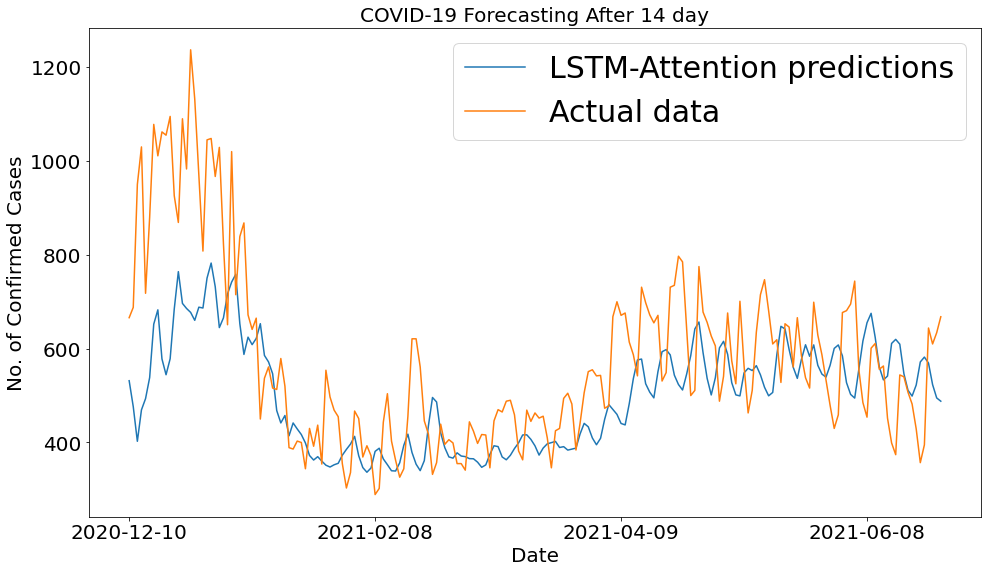

In [ ]:
sum_predict2 = sum_predict2/5
predict2 = sc.inverse_transform(sum_predict2.reshape(-1,1))

print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict2)**0.5)) 
print("PCC : {}".format(plcc_metric(actual,predict2)))
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict2, label = "LSTM-Attention predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 4 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})

In [ ]:
sum_predict3 = 0
for i in range(5):  
  model3 = model_attention_applied_before_lstm()
  model3.compile(loss='mse', optimizer='adam', metrics=['mae'])

  model3.fit(trainX, trainY, epochs=40, batch_size=16)
  prediction3 = model3.predict(testX)
  sum_predict3 += prediction3

Epoch 1/40
20/20 [==============================] - 2s 13ms/step - loss: 0.0351 - mae: 0.1275
Epoch 2/40
20/20 [==============================] - 0s 12ms/step - loss: 0.0291 - mae: 0.1140
Epoch 3/40
20/20 [==============================] - 0s 12ms/step - loss: 0.0286 - mae: 0.1206
Epoch 4/40
20/20 [==============================] - 0s 14ms/step - loss: 0.0281 - mae: 0.1157
Epoch 5/40
20/20 [==============================] - 0s 13ms/step - loss: 0.0270 - mae: 0.1124
Epoch 6/40
20/20 [==============================] - 0s 13ms/step - loss: 0.0256 - mae: 0.1149
Epoch 7/40
20/20 [==============================] - 0s 12ms/step - loss: 0.0233 - mae: 0.1082
Epoch 8/40
20/20 [==============================] - 0s 13ms/step - loss: 0.0209 - mae: 0.1014
Epoch 9/40
20/20 [==============================] - 0s 13ms/step - loss: 0.0194 - mae: 0.0930
Epoch 10/40
20/20 [==============================] - 0s 14ms/step - loss: 0.0183 - mae: 0.0824
Epoch 11/40
20/20 [==============================] - 0s 13m

In [ ]:
sum_predict3 = sum_predict3/5
predict3 = sc.inverse_transform(sum_predict3.reshape(-1,1))

RMSE Evaluate : 126.98309557496704
PCC : 0.7998122572898865


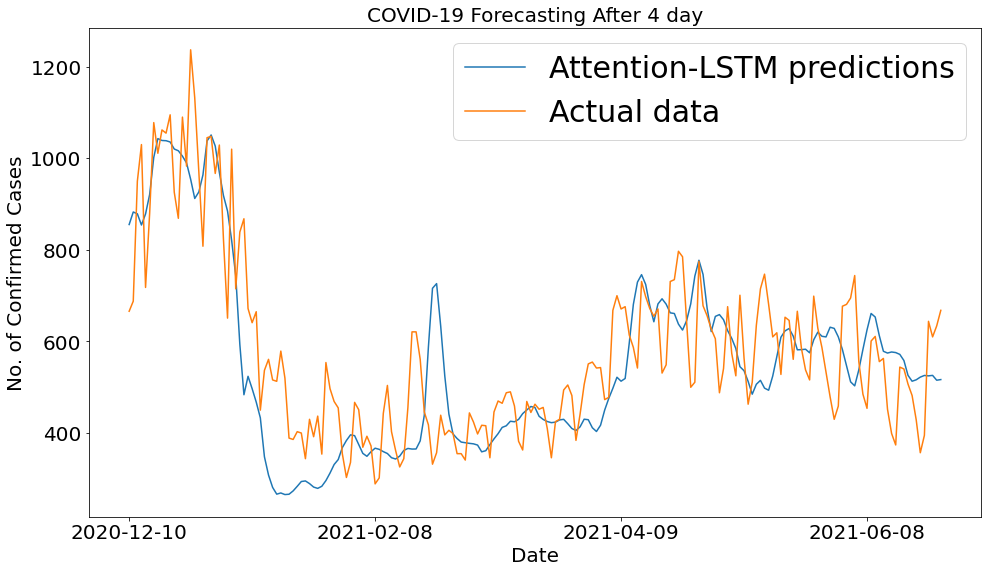

In [ ]:
print("RMSE Evaluate : {}".format(mean_squared_error(actual, predict3)**0.5)) 
print("PCC : {}".format(plcc_metric(actual,predict3)))
plt.figure(figsize=(16, 9))
plt.plot(Date.iloc[trainSize+predict_day:], predict3, label = "Attention-LSTM predictions")
plt.plot(actual,label = "Actual data")
plt.xticks(np.arange(0,240,60), fontsize=20)
plt.yticks(fontsize=20)
plt.title('COVID-19 Forecasting After 4 day',fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('No. of Confirmed Cases' ,fontsize=20)
plt.legend(prop={'size': 30})

16875/16875 [==============================] - 157s 9ms/step - loss: 0.0036 - mae: 0.0100 - val_loss: 3.8688e-07 - val_mae: 4.5111e-04


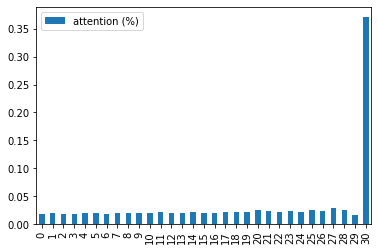

In [ ]:
def get_data_recurrent(n, time_steps, input_dim, attention_column=30):

    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))

    x[:, attention_column, :] = np.tile(y, input_dim)

    return x, y

train_x, train_y = get_data_recurrent(300000, TIME_STEPS, INPUT_DIM)

modelman = model_attention_applied_before_lstm()
#modelman = model_attention_applied_after_lstm()
modelman.compile(optimizer='adam', loss='mse', metrics=['mae'])

modelman.fit([train_x], train_y, epochs=1, batch_size=16, validation_split=0.1)

layer_outputs    = [layer.output for layer in modelman.layers if layer.name == 'attention_vec']
activation_model = tf.keras.models.Model(inputs=modelman.input, outputs=layer_outputs)

attention_vectors = []
for i in range(50):
    test_x, test_y = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)

    predict_output   = activation_model.predict(test_x)
    #print(predict_output.shape)
    dols = np.mean(predict_output, axis=2).squeeze()
    #print(dols,"DOLS",dols.shape)
    
    #assert (np.sum(dols) - 1.0) < 1e-5
    #attention_vectors.append
    attention_vectors.append(dols)

attention_vector_final = np.mean(np.array(attention_vectors), axis=0)

pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot.bar()